In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from lightgbm import LGBMClassifier
from sklearn.cross_validation import *
from sklearn.grid_search import GridSearchCV
import lightgbm as lgb
import re
from sklearn.externals import joblib
import sklearn.metrics as metrics
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
train=pd.read_csv('/home/ashwin/Downloads/happiness/train.csv')
test=pd.read_csv('/home/ashwin/Downloads/happiness/test.csv')

In [3]:
print(train.head())
print(train.shape)
print(test.head())
print(test.shape)

In [4]:
le = preprocessing.LabelEncoder()
target=le.fit_transform(train['Is_Response'])
print( np.bincount(target))

[26521 12411]


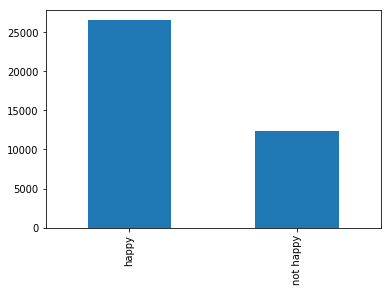

In [5]:
train['Is_Response'].value_counts().plot(kind='bar')

In [6]:
train=train.drop('Is_Response',axis=1)
data=[train,test]
train_test=pd.concat(data,axis=0).reset_index(drop=True)
print(train_test.shape)

(68336, 4)


In [7]:
stops = set(stopwords.words("english"))
def cleanData(text, lowercase = False, remove_stops = False, stemming = False):
    txt = str(text)
    txt = re.sub(r'[^A-Za-z0-9\s]',r'',txt)
    txt = re.sub(r'\n',r' ',txt)
    
    if lowercase:
        txt = " ".join([w.lower() for w in txt.split()])
        
    if remove_stops:
        txt = " ".join([w for w in txt.split() if w not in stops])
    
    if stemming:
        st = WordNetLemmatizer()
        txt = " ".join([st.lemmatize(w) for w in txt.split()])

    return txt

In [8]:
countvec = CountVectorizer(analyzer='word', ngram_range = (1,3), min_df=50, max_features=1500)
tfidfvec = TfidfVectorizer(analyzer='word', ngram_range = (1,3), min_df =50, max_features=1500)

In [10]:
train_test['Description']=train_test['Description'].map(lambda x:cleanData(x,lowercase=True,remove_stops=True,stemming=True))

In [11]:
list(train_test)

['User_ID', 'Description', 'Browser_Used', 'Device_Used']

In [12]:
bagofwords = countvec.fit_transform(train_test['Description'])
tfidfdata = tfidfvec.fit_transform(train_test['Description'])
bow_df = pd.DataFrame(bagofwords.todense())
tfidf_df = pd.DataFrame(tfidfdata.todense())

In [13]:
Browser_Used=pd.get_dummies(train_test['Browser_Used'])
Device_Used=pd.get_dummies(train_test['Device_Used'])

In [14]:
alldata_tf=pd.concat([tfidf_df,Browser_Used,Device_Used],axis=1)
alldata_bow=pd.concat([bow_df,Browser_Used,Device_Used],axis=1)
print(alldata_bow.shape)
print(alldata_tf.shape)

(68336, 1514)
(68336, 1514)


In [15]:
train_bow=alldata_bow[:len(target)]
train_tf=alldata_tf[:len(target)]
test_bow=alldata_bow[len(target):]
test_tf=alldata_tf[len(target):]
print(train_bow.shape,test_bow.shape)
print(train_tf.shape,test_tf.shape)

(38932, 1514) (29404, 1514)
(38932, 1514) (29404, 1514)


In [16]:
sm = SMOTE(random_state=12,ratio=1,n_jobs=-1)
x_synthitic_data_bow,y_synthitic_data_bow = sm.fit_sample(train_bow, target)
x_synthitic_data_tf,y_synthitic_data_tf = sm.fit_sample(train_tf, target)
print(x_synthitic_data_bow.shape)
print( np.bincount(y_synthitic_data_bow))
print(x_synthitic_data_tf.shape)
print( np.bincount(y_synthitic_data_tf))

/home/ashwin/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


/home/ashwin/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


(53042, 1514)
[26521 26521]
(53042, 1514)
[26521 26521]


In [25]:
lgBoost = LGBMClassifier()
param = {'task': ['train'],
         'num_leaves':[200],
         'objective':['binary'],
         'max_depth':[8],
         'learning_rate':[0.05],
         'max_bin':[150],
         'feature_fraction': [0.3], 
         'bagging_fraction': [0.8],
         'metric':['auc']}
clf = GridSearchCV(lgBoost, param_grid=param, n_jobs=1, 
                   cv=StratifiedKFold(y_synthitic_data_bow, n_folds=5, shuffle=True), 
                   scoring='roc_auc',
                   refit=True)
clf.fit(x_synthitic_data_bow,y_synthitic_data_bow)
predictions=clf.predict(train_bow)
print('lightboost Classifier train/validation result')
print('accuracy',metrics.accuracy_score(target,predictions))
print('recall',metrics.recall_score(target,predictions))
print('precision',metrics.precision_score(target,predictions))
print('auc-roc',metrics.roc_auc_score(target,predictions))
pd.crosstab(target, predictions, rownames=['True'], 
            colnames=['Predicted'], margins=True)

test=pd.read_csv('/home/ashwin/Downloads/happiness/test.csv')
predictions=clf.predict(test_tf)
predictions1=['happy' if(x==0) else 'not_happy' for x in predictions ]
submission=pd.DataFrame()
submission['User_ID']=test['User_ID']
submission['Is_Response']=predictions1
submission.to_csv('/home/ashwin/Downloads/happiness/happylgbbow.csv',index=False)

In [26]:
test=pd.read_csv('/home/ashwin/Downloads/happiness/test.csv')
lgBoost_tf = LGBMClassifier()
param = {'task': ['train'],
         'num_leaves':[200],
         'objective':['binary'],
         'max_depth':[8],
         'learning_rate':[0.05],
         'max_bin':[150],
         'feature_fraction': [0.3], 
         'bagging_fraction': [0.8],
         'metric':['auc']}
clf1 = GridSearchCV(lgBoost, param_grid=param, n_jobs=1, 
                   cv=StratifiedKFold(y_synthitic_data_tf, n_folds=3, shuffle=True), 
                   scoring='roc_auc',
                   refit=True)
clf1.fit(x_synthitic_data_tf,y_synthitic_data_tf)
predictions=clf1.predict(train_tf)
print('lightboost Classifier train/validation result')
print('accuracy',metrics.accuracy_score(target,predictions))
print('recall',metrics.recall_score(target,predictions))
print('precision',metrics.precision_score(target,predictions))
print('auc-roc',metrics.roc_auc_score(target,predictions))
pd.crosstab(target, predictions, rownames=['True'], 
            colnames=['Predicted'], margins=True)
predictions=clf1.predict(test_tf)
predictions1=['happy' if(x==0) else 'not_happy' for x in predictions ]
submission=pd.DataFrame()
submission['User_ID']=test['User_ID']
submission['Is_Response']=predictions1
submission.to_csv('/home/ashwin/Downloads/happiness/happylgbtf.csv',index=False)

lightboost Classifier train/validation result
accuracy 0.801859652728
recall 0.577068729353
precision 0.743949309234
auc-roc 0.742061758063


In [27]:
test=pd.read_csv('/home/ashwin/Downloads/happiness/test.csv')
n_estimators=20
model=BaggingClassifier(SVC(C=500,kernel='rbf',gamma=0.01,
     probability=True)
    , max_samples=1.0 / n_estimators, n_estimators=n_estimators,n_jobs=-1)
model.fit(x_synthitic_data_bow,y_synthitic_data_bow)
joblib.dump(model, 'xgboosthappybow.pkl', compress=True)
predictions=model.predict(train_bow)
print('SVM Classifier train/valadiation result')
print('accuracy',metrics.accuracy_score(target,predictions))
print('recall',metrics.recall_score(target,predictions))
print('precision',metrics.precision_score(target,predictions))
print('auc-roc',metrics.roc_auc_score(target,predictions))
pd.crosstab(target, predictions, rownames=['True'], 
            colnames=['Predicted'], margins=True)
predictions=model.predict(test_tf)
predictions1=['happy' if(x==0) else 'not_happy' for x in predictions ]
submission=pd.DataFrame()
submission['User_ID']=test['User_ID']
submission['Is_Response']=predictions1
submission.to_csv('/home/ashwin/Downloads/happiness/happysvmtf.csv'
                  ,index=False)

In [18]:
test=pd.read_csv('/home/ashwin/Downloads/happiness/test.csv')
n_estimators=20
model1=BaggingClassifier(SVC(C=500,kernel='rbf',gamma=0.01,
     probability=True)
    , max_samples=1.0 / n_estimators, n_estimators=n_estimators,n_jobs=-1)
model1.fit(x_synthitic_data_tf,y_synthitic_data_tf)
joblib.dump(model1, 'xgboosthappytf.pkl', compress=True)
predictions=model1.predict(train_tf)
print('SVM Classifier train/valadiation result')
print('accuracy',metrics.accuracy_score(target,predictions))
print('recall',metrics.recall_score(target,predictions))
print('precision',metrics.precision_score(target,predictions))
print('auc-roc',metrics.roc_auc_score(target,predictions))
pd.crosstab(target, predictions, rownames=['True'], 
            colnames=['Predicted'], margins=True)

predictions=model1.predict(test_tf)
predictions1=['happy' if(x==0) else 'not_happy' for x in predictions ]
submission=pd.DataFrame()
submission['User_ID']=test['User_ID']
submission['Is_Response']=predictions1
submission.to_csv('/home/ashwin/Downloads/happiness/happysvmtf1.csv',index=False)

In [ ]:
test=pd.read_csv('/home/ashwin/Downloads/happiness/test.csv')
model = RandomForestClassifier(n_estimators = 500, oob_score = True, 
                n_jobs = -1,random_state =50,max_features = "auto"
                                   , min_samples_leaf = 3)
model.fit(x_synthitic_data_tf,y_synthitic_data_tf)
joblib.dump(model, 'xgboostrf.pkl', compress=True)
predictions=model.predict(train_tf)
print('RandomForest Classifier train/valadiation result')
print('accuracy',metrics.accuracy_score(target,predictions))
print('recall',metrics.recall_score(target,predictions))
print('precision',metrics.precision_score(target,predictions))
print('auc-roc',metrics.roc_auc_score(target,predictions))


predictions=model.predict(test_tf)
predictions1=['happy' if(x==0) else 'not_happy' for x in predictions ]
submission=pd.DataFrame()
submission['User_ID']=test['User_ID']
submission['Is_Response']=predictions1
submission.to_csv('/home/ashwin/Downloads/happiness/happyrf.csv',index=False)

In [ ]:
test=pd.read_csv('/home/ashwin/Downloads/happiness/test.csv')
model=LogisticRegression()
grid_values = {'penalty': ['l2,l1'], 'C': [0.001,0.005,0.01,0.05,0.1
    ,0.5,1,10,100,1000,5000,7500,10000,12500],'class_weight':[{0:.40, 1:.60}],
               'solver' : ['newton-cg','lbfgs','liblinear','sag','saga']}
logistic_model = GridSearchCV(model, param_grid=grid_values,
                cv=StratifiedKFold(y_synthitic_data_tf, n_folds=3, shuffle=True),
                n_jobs=-1,scoring='roc_auc',refit=True)
logistic_model.fit(x_synthitic_data_tf,y_synthitic_data_tf)
joblib.dump(logistic_model, 'xgboostlogistic.pkl', compress=True)
print(logistic_model.best_params_,logistic_model.best_score_)
#model=LogisticRegression(C=1000,penalty='l2')
#model.fit(x_res,y_res)
predictions=logistic_model.predict(train_tf)
print('Logistic Regression Classifier Train/valadiation result')
print('accuracy',metrics.accuracy_score(target,predictions))
print('recall',metrics.recall_score(target,predictions))
print('precision',metrics.precision_score(target,predictions))
print('auc-roc',metrics.roc_auc_score(target,predictions))


predictions=logistic_model.predict(test_tf)
predictions1=['happy' if(x==0) else 'not_happy' for x in predictions ]
submission=pd.DataFrame()
submission['User_ID']=test['User_ID']
submission['Is_Response']=predictions1
submission.to_csv('/home/ashwin/Downloads/happiness/happylogistic.csv',index=False)

In [ ]:
x_synthitic_data_bow['target']=y_synthitic_data_bow
x_synthitic_data_bow.submission.to_csv('/home/ashwin/Downloads/happiness/synthitic_bow.csv',index=False)
x_synthitic_data_tf['target']=y_synthitic_data_tf
x_synthitic_data_tf.submission.to_csv('/home/ashwin/Downloads/happiness/synthitic_tf.csv',index=False)